# Plotting Bathymetric Data in Python

In [1]:
import seaborn as sns 
import numpy as np
import datetime
import rasterio as rio
import importlib
import earthpy as et
import earthpy.plot as ep
import scipy
import scipy.signal
import os
import sys

sys.path.insert(1, os.path.join(sys.path[0], '../data'))
import bathy_meta_data
from matplotlib import pyplot as plt 
from PIL import Image
def reload_modules():
    importlib.reload(bathy_meta_data)

---
## Notes on Parsing Bathymetric Data
- TIF files have helpful meta data encoded in them, such as WGS84 UTM grids: https://www.spatialreference.org/ref/epsg/4326/

---
## Helper Functions 

In [2]:
def archaversine(lat1, lat2, lon1, lon2):
    DEG_TO_RAD = np.pi/180
    lat1 = lat1*DEG_TO_RAD
    lat2 = lat2*DEG_TO_RAD
    lon1 = lon1*DEG_TO_RAD
    lon2 = lon2*DEG_TO_RAD
    R = 6371000
    return(2*R*np.arcsin(((np.sin((lat2-lat1)/2)**2) + 
                           np.cos(lat1)*np.cos(lat2)*(np.sin((lon2-lon1)/2)**2))**0.5))

---
## Data Parsing 

In [32]:
##################################################
# select data file for processing
reload_modules()
data = bathy_meta_data.BathyData['Santorini_full']
SAVE = True

# constants 
RAD_TO_DEG = 180/np.pi


##################################################
# open and parse the bathy file
with rio.open(data['file']) as bathy_dem:
    bathy_meta      = bathy_dem.meta
    bathy_im_h      = bathy_dem.height
    bathy_im_w      = bathy_dem.width
    bathy_im        = np.array(bathy_dem.read()[0], dtype=float)
    bathy           = np.copy(bathy_im).astype(np.float64)
    bathy_nodata    = bathy_dem.meta['nodata']
    bathy_bounds    = bathy_dem.bounds
    bathy_transform = bathy_dem.transform
    bathy_driver    = bathy_dem.driver
    bathy_count     = bathy_dem.count
    bathy_dtype     = bathy_im.dtype
    bathy_crs       = bathy_dem.crs
    delta_x,delta_y = bathy_dem.res
    for _ in bathy_meta:
        print(_, ': \n', bathy_meta[_])
    print()
#     print(bathy_dem.bounds)
#     print(bathy_dem.res)
#     print(bathy_dem.tags(ns="IMAGE_STRUCTURE"))
#     print(bathy_dem.crs.data)
#     print(et.epsg[bathy_dem.crs.data['init'].split(':')[-1]])


##################################################
# filter out no data value from the array
bathy[bathy==bathy_nodata] = np.NaN
bathy[bathy>0] = np.NaN

# filter out depth filter
if data['depth_filter']:
    bathy[-bathy > data['depth_filter']] = np.NaN

# set upper limit on depth for plotting purposes
if data['depth_max']:
    bathy[-bathy > data['depth_max']] = -data['depth_max']


##################################################
# resize the bathy image
if data['AR']:
    bathy_l = bathy_bounds.left
    bathy_r = bathy_bounds.right
    bathy_t = bathy_bounds.top
    bathy_b = bathy_bounds.bottom
    range_y = archaversine(bathy_t, bathy_b, bathy_l, bathy_l)
    range_x = archaversine(bathy_t, bathy_t, bathy_l, bathy_r)
    bathy_w = int(np.round((bathy_im_h + (range_x/range_y)*bathy_im_w) / (range_y/range_x + range_x/range_y)))
    bathy_h = int(np.round((range_y/range_x)*bathy_w))
    bathy   = np.array(Image.fromarray(bathy).resize((bathy_w,bathy_h))).astype(np.float64)
    delta_x, delta_y = range_x/bathy_w, range_y/bathy_h
    

##################################################
# crop data if bounds specified
if data['crop']:
    top, bot, left, right = data['crop']
    bathy    = np.copy(bathy[top:bot, left:right])
    _l, _r   = bathy_bounds.left, bathy_bounds.right
    _t, _b   = bathy_bounds.top,  bathy_bounds.bottom
    # new array width after cropping 
    bathy_w  = right - left
    bathy_h  = bot   - top
    bathy_l  = _l +  (left/bathy_im_w)*(_r - _l)
    bathy_r  = _l + (right/bathy_im_w)*(_r - _l)
    bathy_b  = _t +   (bot/bathy_im_h)*(_b - _t)
    bathy_t  = _t +   (top/bathy_im_h)*(_t - _b)

    
##################################################
# resize the bathy image
if (not data['AR']) and (not data['crop']):
    bathy_l = bathy_bounds.left
    bathy_r = bathy_bounds.right
    bathy_t = bathy_bounds.top
    bathy_b = bathy_bounds.bottom
    bathy_h = bathy_im_h
    bathy_w = bathy_im_w


##################################################
# Scharr operator for computing gradients
scharr = np.array([[ +3 -3j,  +10    , +3 +3j],
                   [    -10j,   0    ,    +10j],
                   [ -3 -3j,  -10    , -3 +3j]]) / 32  # Gx + j*Gy


# compute gradient, slope, and orientation using convolution 
bathy_grad   = scipy.signal.convolve2d(bathy, scharr, boundary='symm', mode='same')/(np.max([delta_x,delta_y]))
bathy_slope  = np.arctan(np.absolute(bathy_grad))*RAD_TO_DEG
bathy_orient = np.angle(bathy_grad)*RAD_TO_DEG

# # filter slope data if required 
if data['slope_max']:
    bathy_slope[bathy_slope > data['slope_max']] = data['slope_max']

if SAVE:
    print(">> Saving Data")
    
    # save bathymetry depth #########################
    with rio.open(
        '/Users/zduguid/Desktop/dat/bathy_depth.tif',
        'w',
        driver=bathy_driver,
        height=bathy_im_h,
        width=bathy_im_w,
        count=bathy_count,
        dtype=bathy_dtype,
        nodata=bathy_nodata,
        crs=bathy_crs,
        transform=bathy_transform
    ) as dst:
        dst.write(-bathy, 1)

    # save bathymetry slope #########################
    with rio.open(
        '/Users/zduguid/Desktop/dat/bathy_slope.tif',
        'w',
        driver=bathy_driver,
        height=bathy_im_h,
        width=bathy_im_w,
        count=bathy_count,
        dtype=bathy_dtype,
        nodata=bathy_nodata,
        crs=bathy_crs,
        transform=bathy_transform
    ) as dst:
        dst.write(bathy_slope, 1)
        
    # save bathymetry orient #########################
    with rio.open(
        '/Users/zduguid/Desktop/dat/bathy_orient.tif',
        'w',
        driver=bathy_driver,
        height=bathy_im_h,
        width=bathy_im_w,
        count=bathy_count,
        dtype=bathy_dtype,
        nodata=bathy_nodata,
        crs=bathy_crs,
        transform=bathy_transform
    ) as dst:
        dst.write(bathy_orient, 1)
        
print('>> Parsing Complete')

driver : 
 GTiff
dtype : 
 float32
nodata : 
 -9999.0
width : 
 7536
height : 
 3848
count : 
 1
crs : 
 EPSG:4326
transform : 
 | 0.00, 0.00, 24.71|
| 0.00,-0.00, 36.82|
| 0.00, 0.00, 1.00|

>> Saving Data
>> Parsing Complete


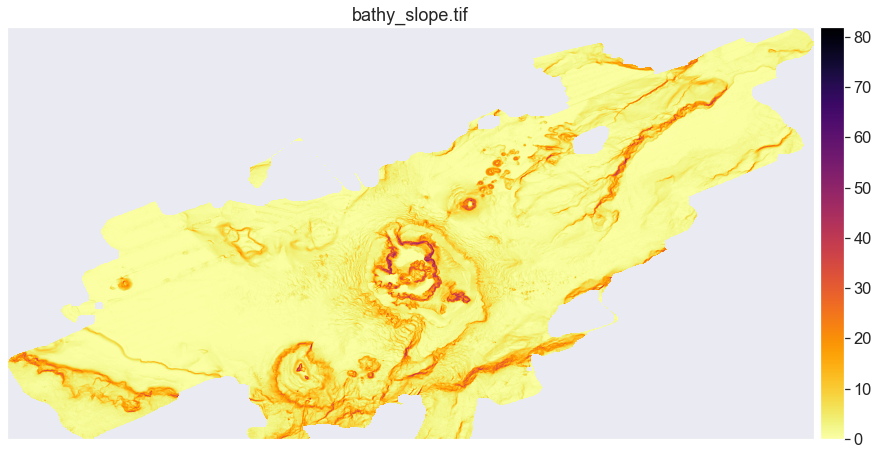

In [33]:
with rio.open('/Users/zduguid/Desktop/dat/bathy_depth.tif') as bathy_dem:
    bathy_depth = np.array(bathy_dem.read()[0], dtype=float)
    
with rio.open('/Users/zduguid/Desktop/dat/bathy_slope.tif') as bathy_dem:
    bathy_slope = np.array(bathy_dem.read()[0], dtype=float)
    
with rio.open('/Users/zduguid/Desktop/dat/bathy_orient.tif') as bathy_dem:
    bathy_orient = np.array(bathy_dem.read()[0], dtype=float)

    
fig, ax = plt.subplots(figsize=(15,8))


# # Plot Bathy Depth
# ep.plot_bands(
#     bathy_depth, 
#     cmap='viridis_r',
#     title="bathy_depth.tif",
#     ax=ax,
#     scale=False
# )
# plt.savefig('/Users/zduguid/Desktop/fig/bathy_depth.png')


# Plot Bathy Slope
ep.plot_bands(
    bathy_slope, 
    cmap='inferno_r',
    title="bathy_slope.tif",
    ax=ax,
    scale=False
)
plt.savefig('/Users/zduguid/Desktop/fig/bathy_slope.png')


# # Plot Bathy Orientation
# ep.plot_bands(
#     bathy_orient, 
#     cmap='twilight_shifted',
#     title="bathy_orient.tif",
#     ax=ax,
#     scale=False
# )
# plt.savefig('/Users/zduguid/Desktop/fig/bathy_orient.png')

## Plot Environment Data

In [5]:
sns.set(font_scale = 1.5)
fig, ax = plt.subplots(2,3, figsize=(15,8), gridspec_kw={'height_ratios': [2, 1]})
fig.subplots_adjust(hspace=.4)
fig.subplots_adjust(wspace=.3)
plt.suptitle(data['title'], fontweight='bold', fontsize=28)


# plot seafloor depth
ep.plot_bands(
    -bathy, 
    cmap='viridis_r',
    title="Depth Map [m]",
    ax=ax[0,0],
    scale=False
)


# plot seafloor slope
ep.plot_bands(
    bathy_slope, 
    cmap='inferno_r',
    title='Gradiant [deg]',
    ax=ax[0,1],
    scale=False
)


# plot seafloor slope orientation 
ep.plot_bands(
    bathy_orient, 
    cmap='twilight_shifted',
    title='Orientation [deg]',
    ax=ax[0,2],
    scale=False
)


sns.kdeplot(-bathy.flatten(),       shade=True, ax=ax[1,0], linewidth=3)
sns.kdeplot(bathy_slope.flatten(),  shade=True, ax=ax[1,1], linewidth=3)
sns.kdeplot(bathy_orient.flatten(), shade=True, ax=ax[1,2], linewidth=3)
ax[1,0].set_xlabel('Depth [m]')
ax[1,1].set_xlabel('Slope [deg]')
ax[1,2].set_xlabel('Orientation [deg]')
xticks  = np.arange(bathy_w/data['num_ticks']/2, bathy_w, bathy_w/data['num_ticks'])
xlabels = [data['ticks'] % np.round((bathy_r-bathy_l)*(i/bathy_w) + bathy_l, 5) for i in xticks]
yticks  = np.arange(bathy_h/data['num_ticks']/2, bathy_h, bathy_h/data['num_ticks'])
ylabels = [data['ticks'] % np.round((bathy_b-bathy_t)*(i/bathy_h) + bathy_t, 5) for i in yticks]


# plot axis labels 
for i in range(3):
    ax[0,i].set_xticks(xticks)
    ax[0,i].set_xticklabels(xlabels)
    ax[0,i].set_yticks(yticks)
    if i==0:
        ax[0,i].set_yticklabels(ylabels)
        ax[0,i].set_ylabel(data['ylabel'])
        ax[1,i].set_ylabel('Kernel Density')
    else:
        ax[0,i].set_yticklabels(['' for _ in ylabels])
    ax[0,i].set_xlabel(data['xlabel'])
    ax[0,i].grid(linewidth=1, alpha=1, color='lavenderblush')
plt.savefig('/Users/zduguid/Desktop/fig/tmp.png')
print('>> Plotting Complete')
plt.show()

KeyboardInterrupt: 

Error in callback <function flush_figures at 0x123fe0950> (for post_execute):


KeyboardInterrupt: 

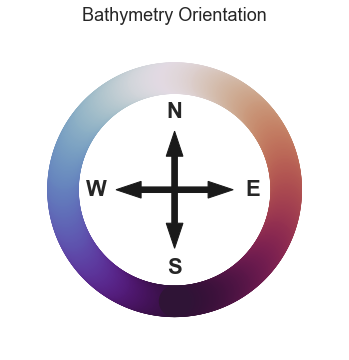

In [259]:
sns.set(font_scale = 1.5)
fig, ax = plt.subplots(figsize=(6,6))
theta = np.linspace(-np.pi,np.pi,500)
x = np.sin(theta)
y = np.cos(theta)
sns.scatterplot(
    x=x,
    y=y,
    hue=theta,
    palette='twilight_shifted',
    linewidth=0,
    legend=False,
    s=1000,
)
# plt.ticks(False)
plt.grid(False)
plt.axis('equal')
plt.axis('off')
plt.title('Bathymetry Orientation')
plt.arrow(0,0, 0.3,   0,color='k',width=0.05)
plt.arrow(0,0,-0.3,   0,color='k',width=0.05)
plt.arrow(0,0,   0, 0.3,color='k',width=0.05)
plt.arrow(0,0,   0,-0.3,color='k',width=0.05)
plt.text(0.7,0.0,'E',verticalalignment='center',horizontalalignment='center',fontsize=22, fontweight='bold')
plt.text(0.0,0.7,'N',verticalalignment='center',horizontalalignment='center',fontsize=22, fontweight='bold')
plt.text(0.0,-0.7,'S',verticalalignment='center',horizontalalignment='center',fontsize=22, fontweight='bold')
plt.text(-0.7,0.0,'W',verticalalignment='center',horizontalalignment='center',fontsize=22, fontweight='bold')
plt.xlim(-1.5,1.5)
plt.ylim(-1.5,1.5)
plt.savefig('/Users/zduguid/Downloads/orientation-interpretation.png')